In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


<Axes: xlabel='SalePrice', ylabel='Count'>

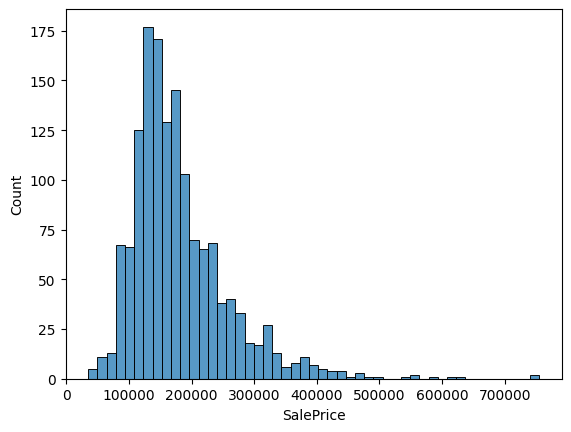

In [2]:
sns.histplot(train_df["SalePrice"])

<Axes: xlabel='SalePrice', ylabel='Count'>

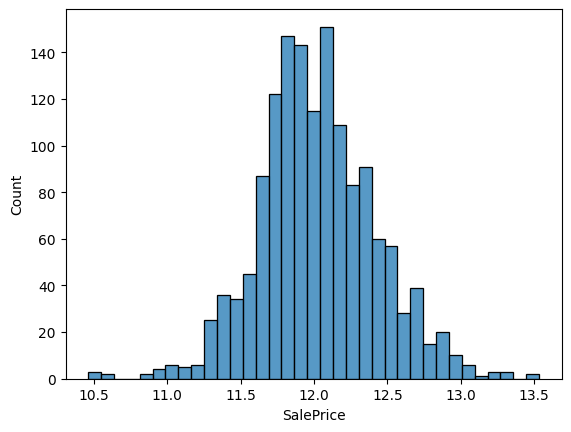

In [3]:
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])
sns.histplot(train_df['SalePrice'])

In [4]:
print('SalePrice' in train_df.columns)

True


<Axes: >

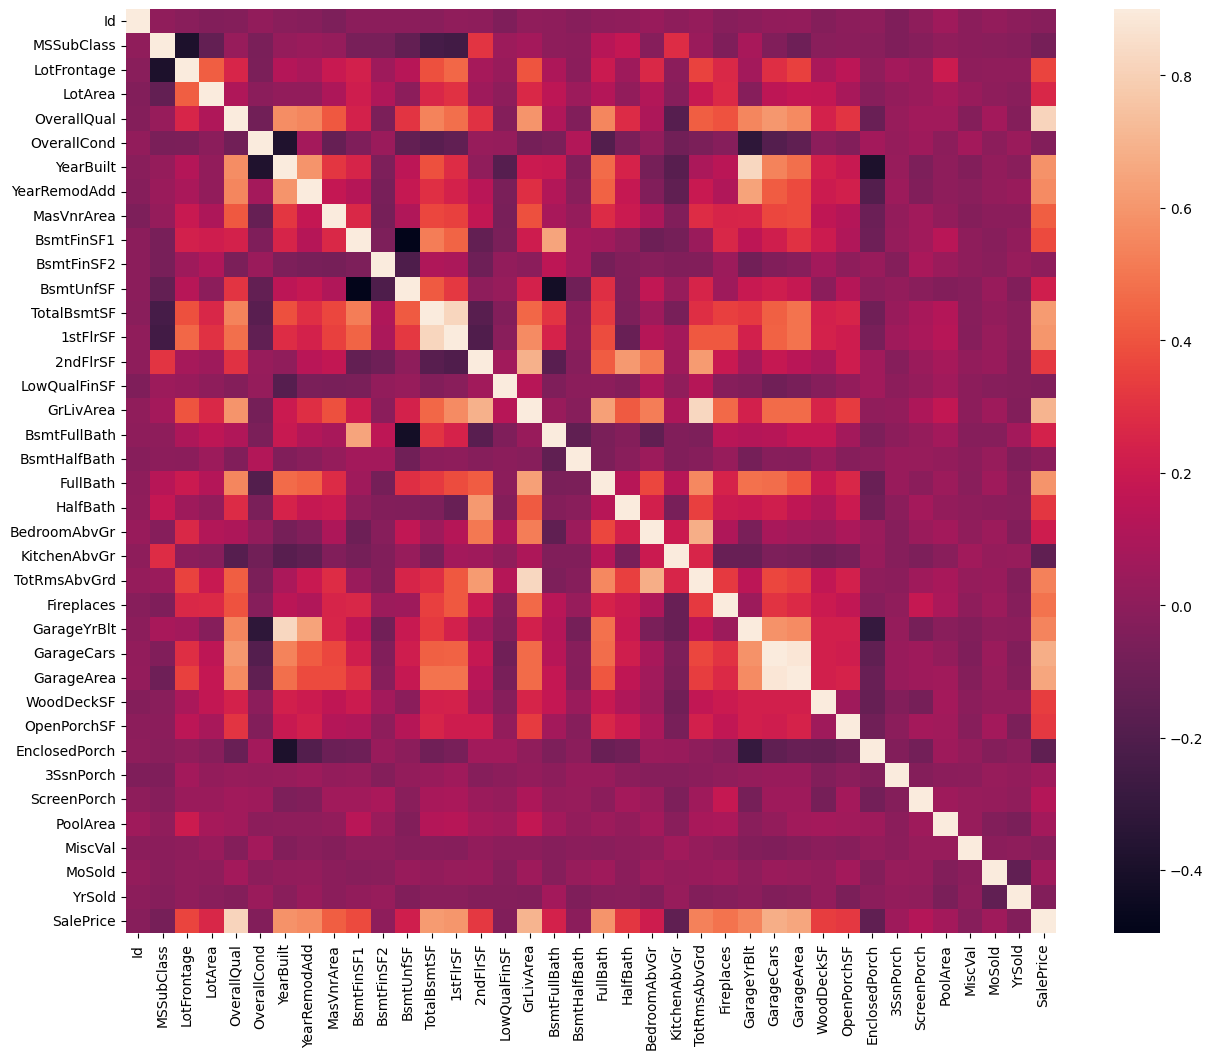

In [5]:
corrmat = train_df.corr(numeric_only=True)
plt.figure(figsize=(15, 12))
sns.heatmap(corrmat, vmax=0.9)

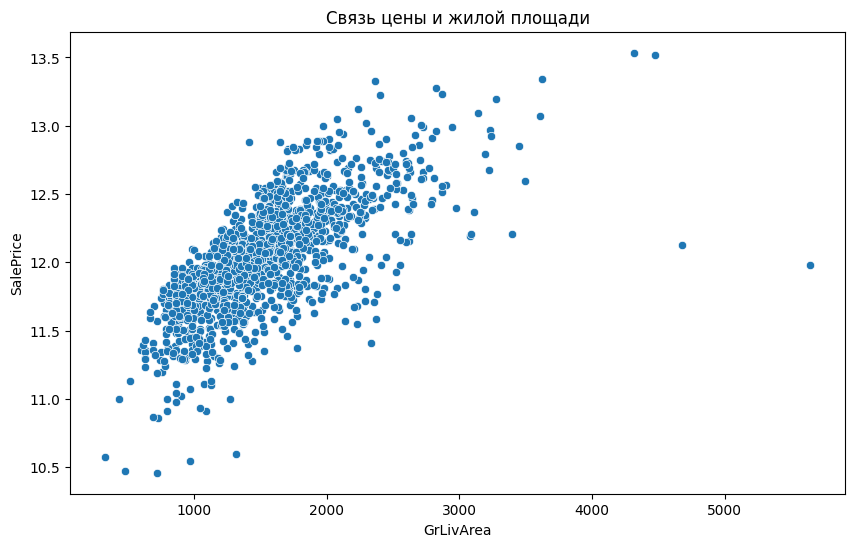

In [6]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train_df)
plt.title('Связь цены и жилой площади')
plt.show()

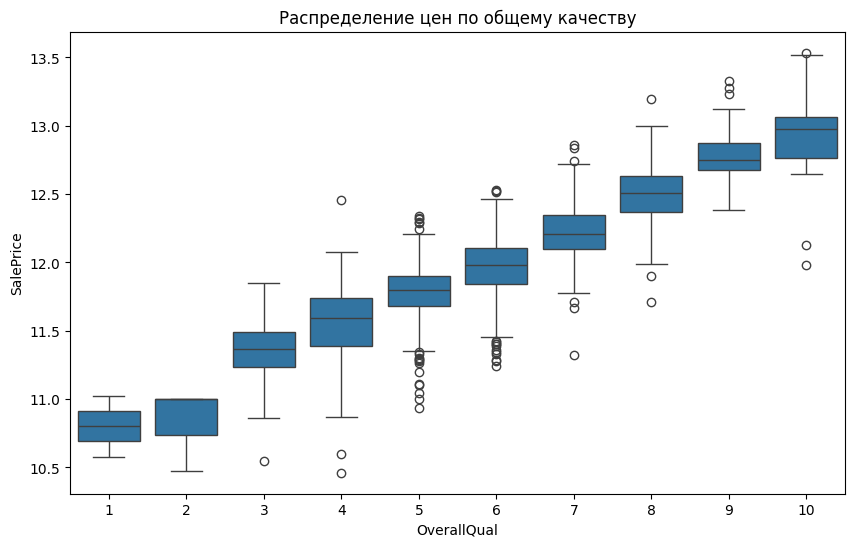

In [7]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='OverallQual', y='SalePrice', data=train_df)
plt.title('Распределение цен по общему качеству')
plt.show()

In [8]:
outliers_to_drop = train_df[(train_df['GrLivArea'] > 4000) & (train_df['SalePrice'] < 13.0)].index
print(outliers_to_drop)
print(f"Текущий размер тренировочного датасета: {train_df.shape}")
train_df = train_df.drop(outliers_to_drop)
print(f"Удалено {len(outliers_to_drop)} выброса.")
print(f"Новый размер тренировочного датасета: {train_df.shape}")

Index([523, 1298], dtype='int64')
Текущий размер тренировочного датасета: (1460, 81)
Удалено 2 выброса.
Новый размер тренировочного датасета: (1458, 81)


In [9]:
test_ids = test_df['Id']
y_train = train_df['SalePrice']
train_df = train_df.drop(['Id', 'SalePrice'], axis=1)
test_df = test_df.drop('Id', axis=1)

all_data = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)

заполнение пропусков в данных

In [10]:
for col in ('Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
            'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
            'PoolQC', 'Fence', 'MiscFeature', 'MasVnrType'):
    all_data[col] = all_data[col].fillna('None')

for col in ('MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF',
            'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea'):
    all_data[col] = all_data[col].fillna(0)

all_data['GarageYrBlt'] = all_data['GarageYrBlt'].fillna(all_data['GarageYrBlt'].mode()[0])

all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median()))

all_data['LotFrontage'] = all_data['LotFrontage'].fillna(all_data['LotFrontage'].median())

for col in ('MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Functional', 'Utilities'):
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

In [11]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [12]:
all_data_final = pd.get_dummies(all_data).reset_index(drop=True)

In [13]:
X_train = all_data_final.iloc[:len(y_train)]
X_test = all_data_final.iloc[len(y_train):]

print("Размер тренировочной выборки:", X_train.shape)
print("Размер тестовой выборки:", X_test.shape)

Размер тренировочной выборки: (1458, 302)
Размер тестовой выборки: (1459, 302)


In [14]:
nan_in_X_train = X_train.isnull().sum().sum()
nan_in_y_train = y_train.isnull().sum()

if nan_in_X_train > 0 or nan_in_y_train > 0:
    print(f"Обнаружены пропущенные значения")
    print(f"Количество NaN в X_train: {nan_in_X_train}")
    print(f"Количество NaN в y_train: {nan_in_y_train}")

    print("\nКолонки с NaN в X_train:")
    print(X_train.isnull().sum()[X_train.isnull().sum() > 0])
else:
    print("Пропущенных значений не обнаружено")

Пропущенных значений не обнаружено


In [15]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
import lightgbm as lgb

kf = KFold(n_splits=5, shuffle=True, random_state=42)
lr = LinearRegression()
lr_scores = cross_val_score(lr, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error')

lgbm = lgb.LGBMRegressor(random_state=42)
lgbm_scores = cross_val_score(lgbm, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error')

print(f"Средний RMSE для Linear Regression: {-lr_scores.mean():.4f}")
print(f"Средний RMSE для LightGBM: {-lgbm_scores.mean():.4f}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3461
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 194
[LightGBM] [Info] Start training from score 12.023362
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3459
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 195
[LightGBM] [Info] Start training from score 12.026498
[LightGBM] [Warning] Found

In [16]:
import lightgbm as lgb

final_model = lgb.LGBMRegressor(objective='fair',
                                n_estimators=1000,
                                learning_rate=0.01,
                                num_leaves=2**8,
                                max_depth=8,
                                min_child_samples=30,
                                subsample=0.8,
                                colsample_bytree=0.8,
                                reg_alpha=0.1,
                                reg_lambda=1.0,
                                random_state=42,
                                n_jobs=-1,
                                verbose=-1)

lgbm_params_scores = cross_val_score(final_model, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error')
print(f"Средний RMSE для LightGBM с гиперпараметрами: {-lgbm_params_scores.mean():.4f}")

final_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train)],
    eval_metric='rmse'
)

predictions_log = final_model.predict(X_test)

final_predictions = np.expm1(predictions_log)

submission = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': final_predictions
})

submission.to_csv('submission.csv', index=False)

Средний RMSE для LightGBM с гиперпараметрами: 0.1244
